In [1]:
import time
start = time.perf_counter()

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

2026-02-19 14:01:50.484416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771527710.499456   15984 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771527710.503952   15984 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771527710.515398   15984 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771527710.515416   15984 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771527710.515418   15984 computation_placer.cc:177] computation placer alr

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/ex_train.csv')
val_df = pd.read_csv('../data/ex_val.csv')
test_df = pd.read_csv('../data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Single-step model 

### CNN 

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['NO2'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['NO2'])

In [10]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

I0000 00:00:1771527712.191882   15984 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9823 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Epoch 1/50


I0000 00:00:1771527714.288366   16015 service.cc:152] XLA service 0x7843e40094d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771527714.288381   16015 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2026-02-19 14:01:54.313020: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1771527714.429306   16015 cuda_dnn.cc:529] Loaded cuDNN version 90300


 66/414 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0671

I0000 00:00:1771527714.971774   16015 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0388 - val_loss: 0.0022 - val_mean_absolute_error: 0.0324
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0291 - val_loss: 0.0019 - val_mean_absolute_error: 0.0280
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0279 - val_loss: 0.0019 - val_mean_absolute_error: 0.0277
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0279 - val_loss: 0.0018 - val_mean_absolute_error: 0.0271
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0271 - val_loss: 0.0022 - val_mean_absolute_error: 0.0324
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0271 - val_loss: 0.0019 - val_mean_absolute_error: 0.0285
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0270 - val_loss: 0.

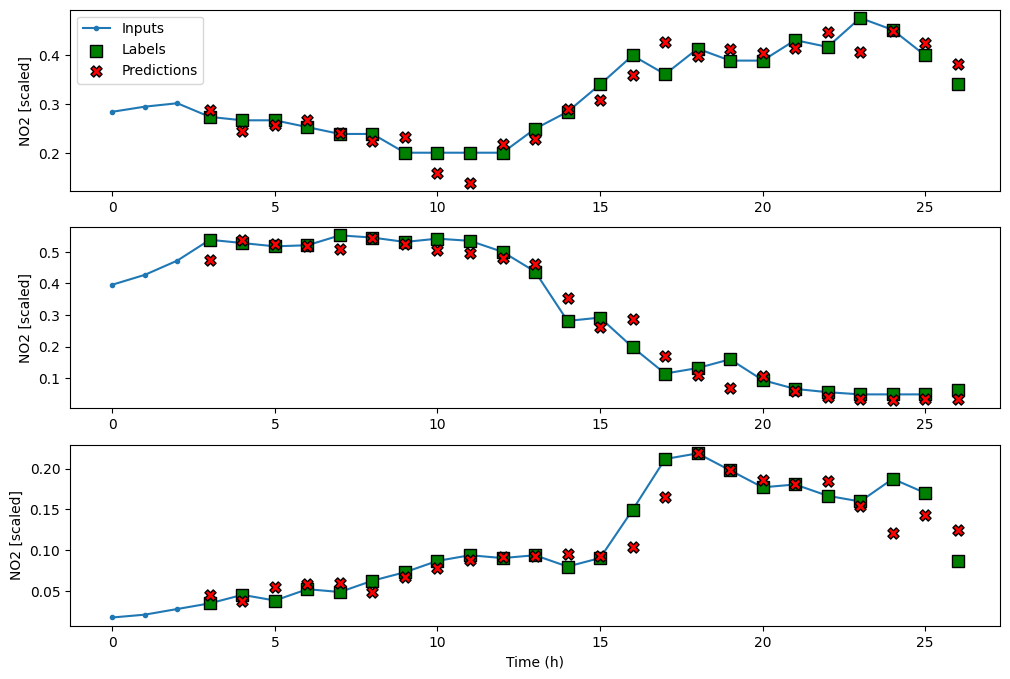

In [11]:
wide_conv_window.plot(cnn_model)

### CNN + LSTM 

In [12]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0507 - val_loss: 0.0024 - val_mean_absolute_error: 0.0356
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0299 - val_loss: 0.0019 - val_mean_absolute_error: 0.0295
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0285 - val_loss: 0.0022 - val_mean_absolute_error: 0.0329
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0278 - val_loss: 0.0020 - val_mean_absolute_error: 0.0296
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0272 - val_loss: 0.0018 - val_mean_absolute_error: 0.0274
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0266 - val_loss: 0.0020 - val_mean_absolute_error: 0.0301
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0265 - v

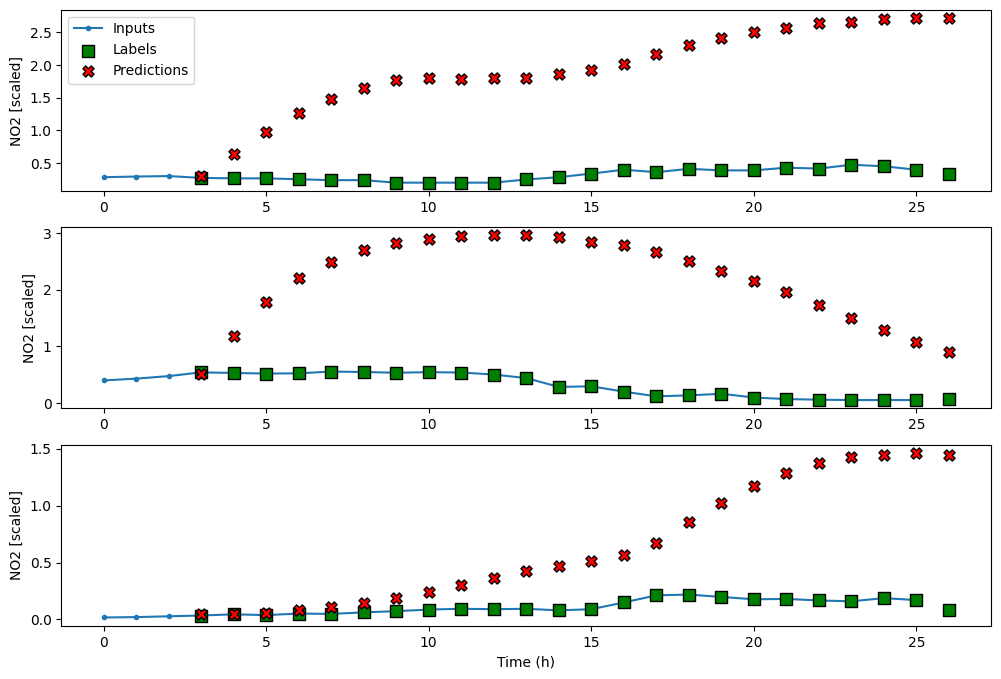

In [13]:
wide_conv_window.plot(cnn_lstm_model)

In [14]:
# Values obtained from chapter 15

mae_val = [0.029, 0.028, 0.029, 0.027]
mae_test = [0.033, 0.032, 0.034, 0.033]

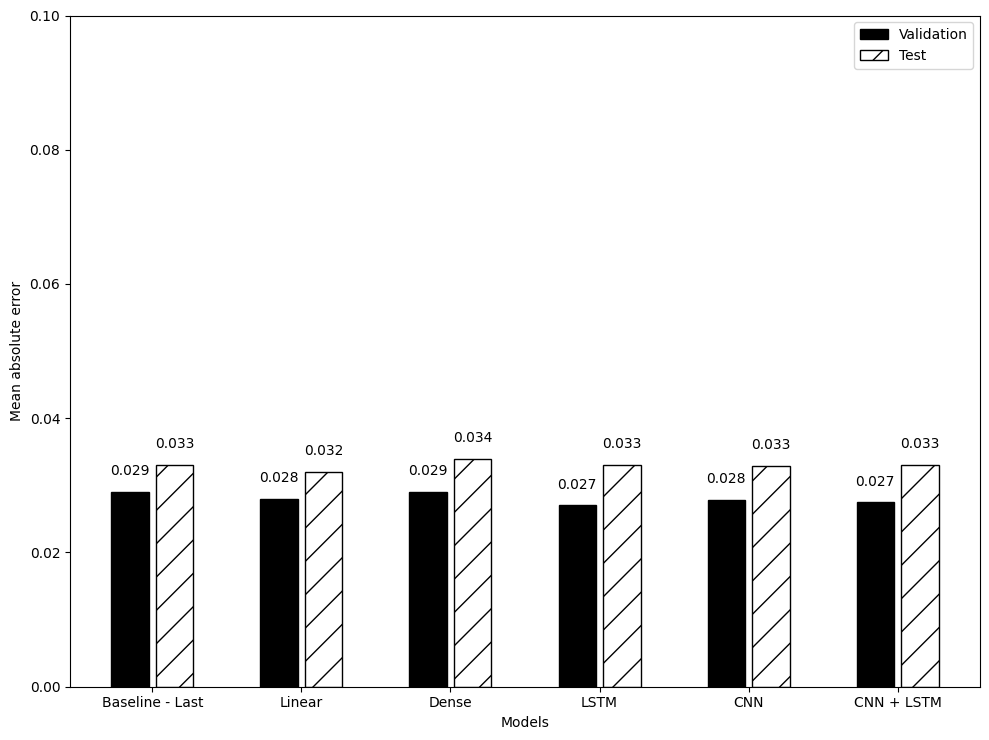

In [15]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model 

### CNN 

In [16]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['NO2'])

In [17]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_conv_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0135 - mean_absolute_error: 0.0880 - val_loss: 0.0085 - val_mean_absolute_error: 0.0685
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - mean_absolute_error: 0.0799 - val_loss: 0.0085 - val_mean_absolute_error: 0.0684
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0785 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0778 - val_loss: 0.0086 - val_mean_absolute_error: 0.0691
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0691


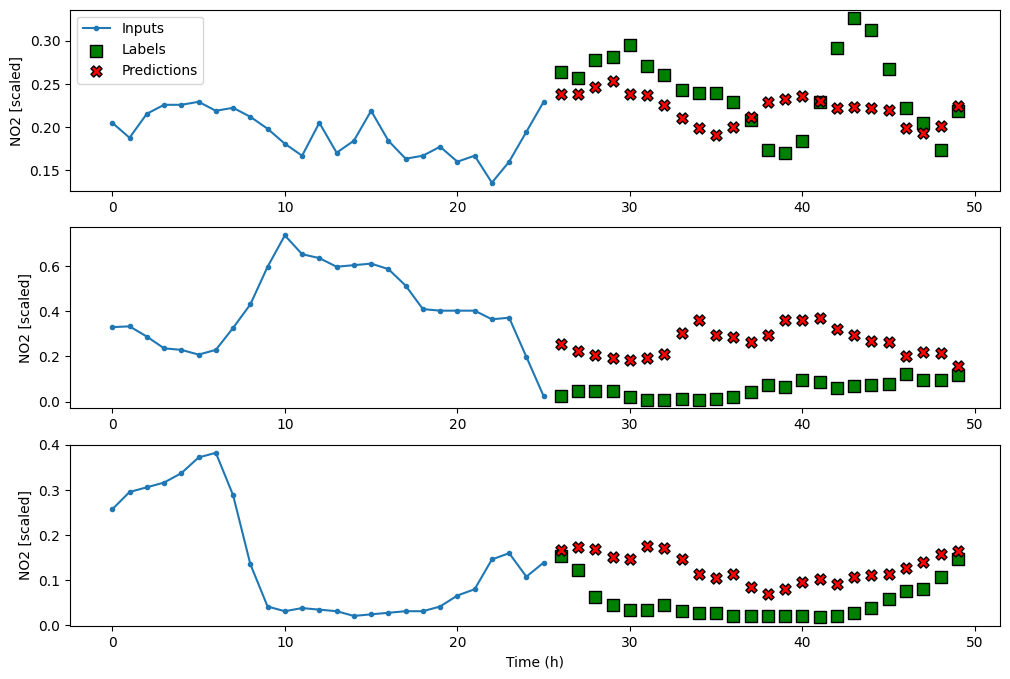

In [18]:
multi_conv_window.plot(ms_cnn_model)

### CNN + LSTM

In [19]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_conv_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0138 - mean_absolute_error: 0.0890 - val_loss: 0.0088 - val_mean_absolute_error: 0.0716
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0114 - mean_absolute_error: 0.0810 - val_loss: 0.0094 - val_mean_absolute_error: 0.0715
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0109 - mean_absolute_error: 0.0791 - val_loss: 0.0084 - val_mean_absolute_error: 0.0682
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0106 - mean_absolute_error: 0.0779 - val_loss: 0.0085 - val_mean_absolute_error: 0.0684
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0105 - mean_absolute_error: 0.0774 - val_loss: 0.0083 - val_mean_absolute_error: 0.0679
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0103 - mean_absolute_error: 0.0767 - val_loss: 0.0086 - val_mean_absolute_error: 0.0686
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0101 - mean_absolute_error: 0.0762 - v

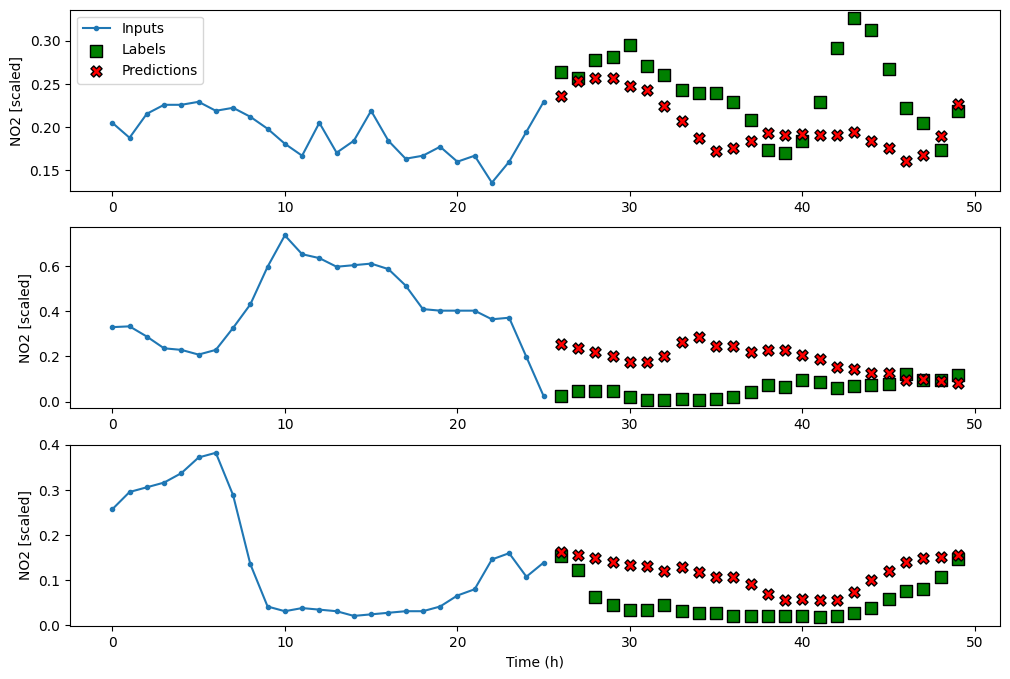

In [20]:
multi_conv_window.plot(ms_cnn_lstm_model)

In [21]:
# Values obtained from chapter 15

ms_mae_val = [0.282, 0.282, 0.070, 0.071, 0.069]
ms_mae_test = [0.243, 0.244, 0.115, 0.114, 0.114]

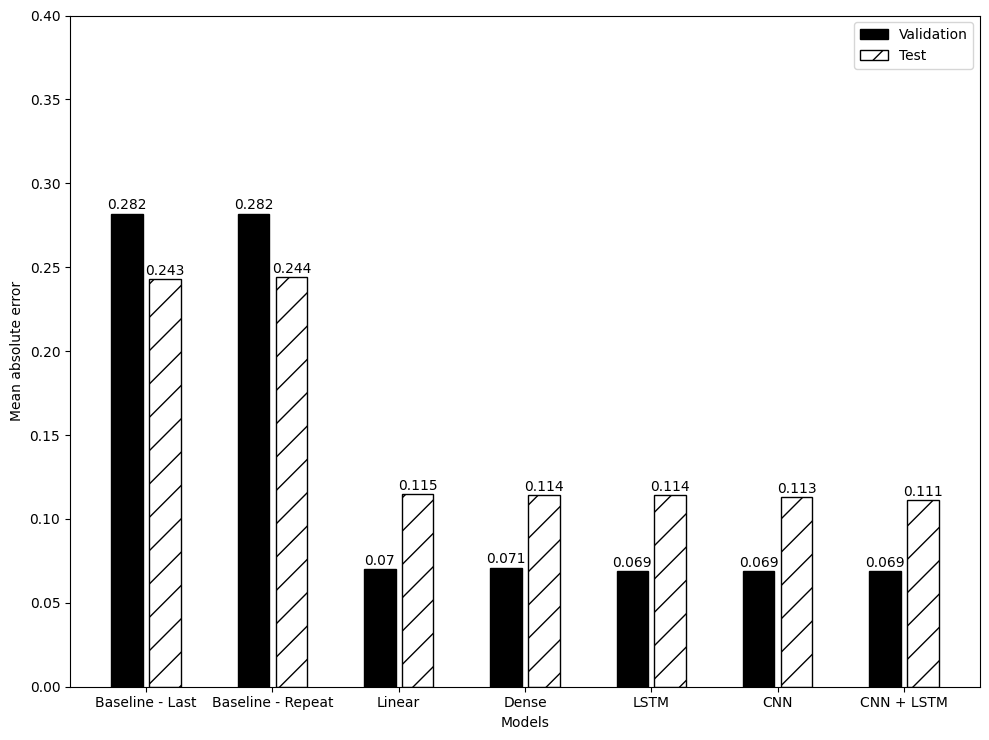

In [22]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output model
### CNN

In [23]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['NO2', 'TEMP'])

In [24]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0067 - mean_absolute_error: 0.0467 - val_loss: 0.0014 - val_mean_absolute_error: 0.0255
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0238 - val_loss: 0.0012 - val_mean_absolute_error: 0.0225
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0217 - val_loss: 0.0011 - val_mean_absolute_error: 0.0217
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7463e-04 - mean_absolute_error: 0.0207 - val_loss: 0.0011 - val_mean_absolute_error: 0.0212
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3377e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0011 - val_mean_absolute_error: 0.0205
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0967e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0011 - val_mean_absolute_error: 0.0201
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.9471e-04 - mean_absolute_e

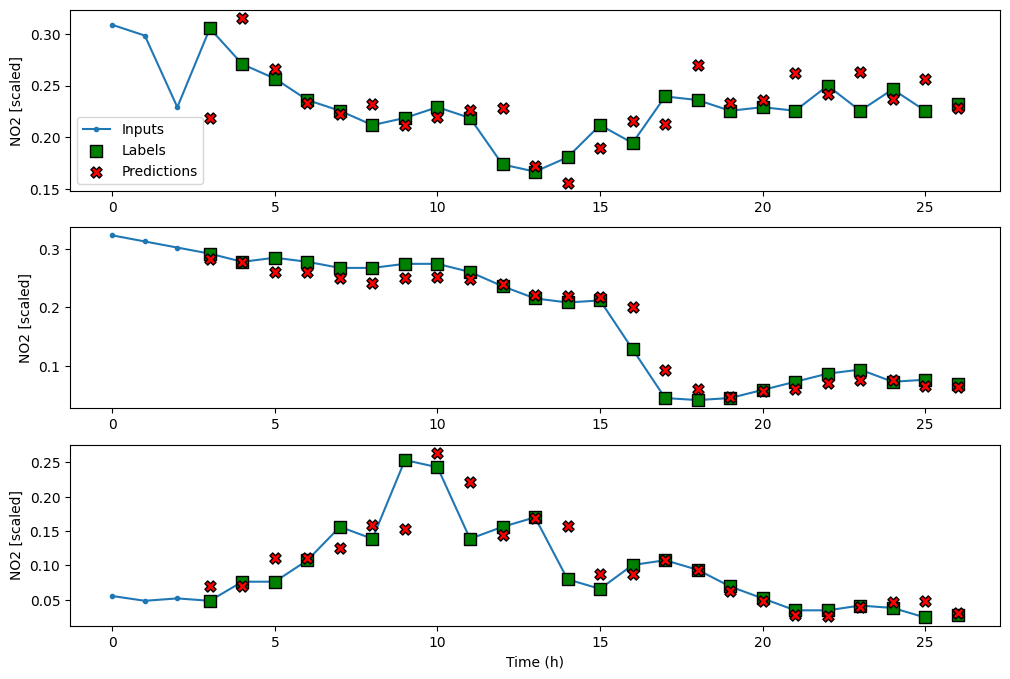

In [25]:
wide_mo_conv_window.plot(mo_cnn_model)

### CNN + LSTM

In [26]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0089 - mean_absolute_error: 0.0574 - val_loss: 0.0018 - val_mean_absolute_error: 0.0296
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0280 - val_loss: 0.0014 - val_mean_absolute_error: 0.0264
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0243 - val_loss: 0.0012 - val_mean_absolute_error: 0.0224
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0219 - val_loss: 0.0011 - val_mean_absolute_error: 0.0212
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.9062e-04 - mean_absolute_error: 0.0209 - val_loss: 0.0011 - val_mean_absolute_error: 0.0212
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.4860e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0011 - val_mean_absolute_error: 0.0201
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.2004e-04 - mean_absolute_error

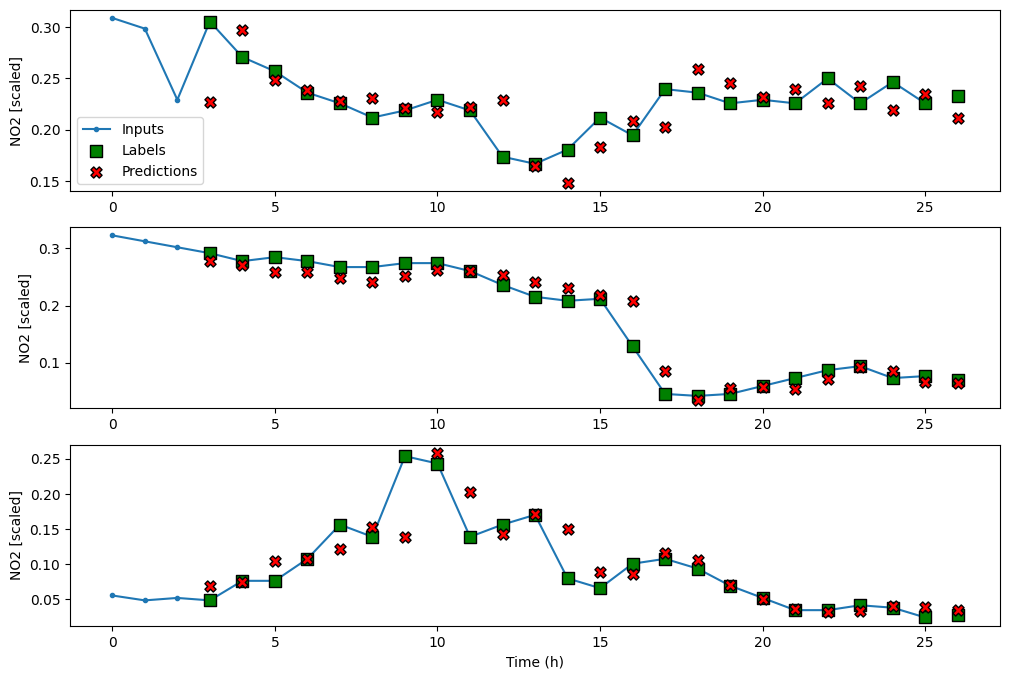

In [27]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

In [28]:
# Values from chapter 15

mo_mae_val = [0.021, 0.020, 0.020, 0.019]
mo_mae_test = [0.025, 0.023, 0.025, 0.022]

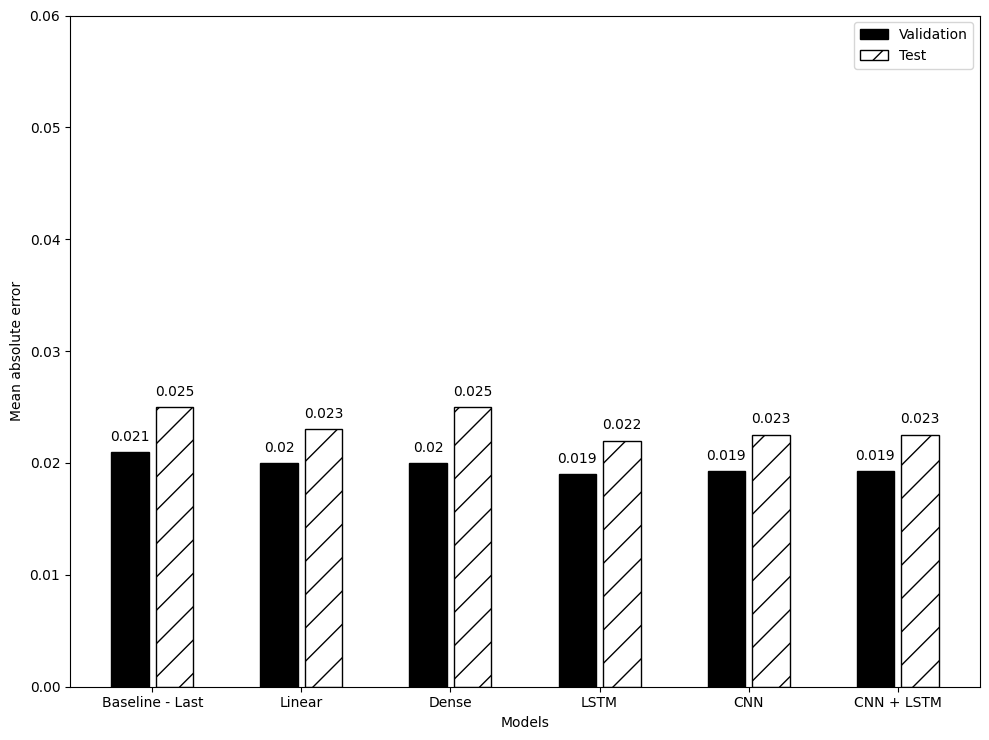

In [29]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [30]:
end = time.perf_counter()

elapsed_time = end - start
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Elapsed time: 168.7701 seconds


Python 3.12, tensorflow 2.19.1, Elapsed time: 168.7701 seconds